In [1]:
# pip install torch

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
from  torch import nn
from torch.utils.data import DataLoader, TensorDataset

In [3]:
# read data
diagnosis_df = pd.read_csv('./ed_data/diagnosis.csv')
edstays_df = pd.read_csv('./ed_data/edstays.csv')
medrecon_df = pd.read_csv('./ed_data/medrecon.csv')
pyxis_df = pd.read_csv('./ed_data/pyxis.csv')
triage_df = pd.read_csv('./ed_data/triage.csv')
vitalsign_df = pd.read_csv('./ed_data/vitalsign.csv')

In [4]:
diagnosis_df.head()

,subject_id,stay_id,seq_num,icd_code,icd_version,icd_title
0,10000032,32952584,1,4589,9,HYPOTENSION NOS
1,10000032,32952584,2,07070,9,UNSPECIFIED VIRAL HEPATITIS C WITHOUT HEPATIC ...
2,10000032,32952584,3,V08,9,ASYMPTOMATIC HIV INFECTION
3,10000032,33258284,1,5728,9,"OTH SEQUELA, CHR LIV DIS"
4,10000032,33258284,2,78959,9,OTHER ASCITES


# Preprocess

In [5]:
# convert to object dtype
def convert_dtype(df, columns, dtype):
    for col in columns:
        if col in df.columns:
            try:
                df[col] = df[col].astype(dtype)
            except ValueError as e:
                print(f"Error converting column {col}, {e}")
        else:
            print(f"Column {col} does not exist in {df}")
    return df

In [6]:
diagnosis_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899050 entries, 0 to 899049
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   subject_id   899050 non-null  int64 
 1   stay_id      899050 non-null  int64 
 2   seq_num      899050 non-null  int64 
 3   icd_code     899050 non-null  object
 4   icd_version  899050 non-null  int64 
 5   icd_title    899050 non-null  object
dtypes: int64(4), object(2)
memory usage: 41.2+ MB


In [7]:
columns = ["subject_id", "stay_id", "icd_version"]
diagnosis_df = convert_dtype(diagnosis_df, columns, object)

In [8]:
diagnosis_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899050 entries, 0 to 899049
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   subject_id   899050 non-null  object
 1   stay_id      899050 non-null  object
 2   seq_num      899050 non-null  int64 
 3   icd_code     899050 non-null  object
 4   icd_version  899050 non-null  object
 5   icd_title    899050 non-null  object
dtypes: int64(1), object(5)
memory usage: 41.2+ MB


In [9]:
edstays_df.head()

,subject_id,hadm_id,stay_id,intime,outtime,gender,race,arrival_transport,disposition
0,10000032,22595853.0,33258284,2180-05-06 19:17:00,2180-05-06 23:30:00,F,WHITE,AMBULANCE,ADMITTED
1,10000032,22841357.0,38112554,2180-06-26 15:54:00,2180-06-26 21:31:00,F,WHITE,AMBULANCE,ADMITTED
2,10000032,25742920.0,35968195,2180-08-05 20:58:00,2180-08-06 01:44:00,F,WHITE,AMBULANCE,ADMITTED
3,10000032,29079034.0,32952584,2180-07-22 16:24:00,2180-07-23 05:54:00,F,WHITE,AMBULANCE,HOME
4,10000032,29079034.0,39399961,2180-07-23 05:54:00,2180-07-23 14:00:00,F,WHITE,AMBULANCE,ADMITTED


In [10]:
edstays_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425087 entries, 0 to 425086
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   subject_id         425087 non-null  int64  
 1   hadm_id            203016 non-null  float64
 2   stay_id            425087 non-null  int64  
 3   intime             425087 non-null  object 
 4   outtime            425087 non-null  object 
 5   gender             425087 non-null  object 
 6   race               425087 non-null  object 
 7   arrival_transport  425087 non-null  object 
 8   disposition        425087 non-null  object 
dtypes: float64(1), int64(2), object(6)
memory usage: 29.2+ MB


In [11]:
columns = ["subject_id", "hadm_id", "stay_id"]
edstays_df = convert_dtype(edstays_df, columns, object)

In [12]:
edstays_df["intime"] = pd.to_datetime(edstays_df["intime"])
edstays_df["outtime"] = pd.to_datetime(edstays_df["outtime"])

In [13]:
edstays_df = convert_dtype(edstays_df, ["gender"], bool)

In [14]:
edstays_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425087 entries, 0 to 425086
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   subject_id         425087 non-null  object        
 1   hadm_id            203016 non-null  object        
 2   stay_id            425087 non-null  object        
 3   intime             425087 non-null  datetime64[ns]
 4   outtime            425087 non-null  datetime64[ns]
 5   gender             425087 non-null  bool          
 6   race               425087 non-null  object        
 7   arrival_transport  425087 non-null  object        
 8   disposition        425087 non-null  object        
dtypes: bool(1), datetime64[ns](2), object(6)
memory usage: 26.4+ MB


In [15]:
medrecon_df.head()

,subject_id,stay_id,charttime,name,gsn,ndc,etc_rn,etccode,etcdescription
0,10000032,32952584,2180-07-22 17:26:00,albuterol sulfate,28090,21695042308,1,5970.0,Asthma/COPD Therapy - Beta 2-Adrenergic Agents...
1,10000032,32952584,2180-07-22 17:26:00,calcium carbonate,1340,10135021101,1,733.0,Minerals and Electrolytes - Calcium Replacement
2,10000032,32952584,2180-07-22 17:26:00,cholecalciferol (vitamin D3),65241,37205024678,1,670.0,Vitamins - D Derivatives
3,10000032,32952584,2180-07-22 17:26:00,emtricitabine-tenofovir [Truvada],57883,35356007003,1,5849.0,Antiretroviral - Nucleoside and Nucleotide Ana...
4,10000032,32952584,2180-07-22 17:26:00,fluticasone [Flovent HFA],21251,49999061401,1,371.0,Asthma Therapy - Inhaled Corticosteroids (Gluc...


In [16]:
medrecon_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2987342 entries, 0 to 2987341
Data columns (total 9 columns):
 #   Column          Dtype  
---  ------          -----  
 0   subject_id      int64  
 1   stay_id         int64  
 2   charttime       object 
 3   name            object 
 4   gsn             int64  
 5   ndc             int64  
 6   etc_rn          int64  
 7   etccode         float64
 8   etcdescription  object 
dtypes: float64(1), int64(5), object(3)
memory usage: 205.1+ MB


In [17]:
columns = ["subject_id", "stay_id"]
medrecon_df = convert_dtype(medrecon_df, columns, object)

In [18]:
medrecon_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2987342 entries, 0 to 2987341
Data columns (total 9 columns):
 #   Column          Dtype  
---  ------          -----  
 0   subject_id      object 
 1   stay_id         object 
 2   charttime       object 
 3   name            object 
 4   gsn             int64  
 5   ndc             int64  
 6   etc_rn          int64  
 7   etccode         float64
 8   etcdescription  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 205.1+ MB


In [19]:
pyxis_df.head()

,subject_id,stay_id,charttime,med_rn,name,gsn_rn,gsn
0,10000032,32952584,2180-07-22 17:59:00,1,Albuterol Inhaler,1,5037.0
1,10000032,32952584,2180-07-22 17:59:00,1,Albuterol Inhaler,2,28090.0
2,10000032,35968195,2180-08-05 22:29:00,1,Morphine,1,4080.0
3,10000032,35968195,2180-08-05 22:55:00,2,Donnatol (Elixir),1,4773.0
4,10000032,35968195,2180-08-05 22:55:00,3,Aluminum-Magnesium Hydrox.-Simet,1,2701.0


In [20]:
pyxis_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1586053 entries, 0 to 1586052
Data columns (total 7 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   subject_id  1586053 non-null  int64  
 1   stay_id     1586053 non-null  int64  
 2   charttime   1586053 non-null  object 
 3   med_rn      1586053 non-null  int64  
 4   name        1586053 non-null  object 
 5   gsn_rn      1586053 non-null  int64  
 6   gsn         1550601 non-null  float64
dtypes: float64(1), int64(4), object(2)
memory usage: 84.7+ MB


In [21]:
# Also, might not be relevant for the analysis as we want to use data in the first few hours
columns = ["subject_id", "stay_id"]
pyxis_df = convert_dtype(pyxis_df, columns, object)

In [22]:
triage_df.head()

,subject_id,stay_id,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity,chiefcomplaint
0,10000032,32952584,97.8,87.0,14.0,97.0,71.0,43.0,7,2.0,Hypotension
1,10000032,33258284,98.4,70.0,16.0,97.0,106.0,63.0,0,3.0,"Abd pain, Abdominal distention"
2,10000032,35968195,99.4,105.0,18.0,96.0,106.0,57.0,10,3.0,"n/v/d, Abd pain"
3,10000032,38112554,98.9,88.0,18.0,97.0,116.0,88.0,10,3.0,Abdominal distention
4,10000032,39399961,98.7,77.0,16.0,98.0,96.0,50.0,13,2.0,"Abdominal distention, Abd pain, LETHAGIC"


In [23]:
triage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425087 entries, 0 to 425086
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   subject_id      425087 non-null  int64  
 1   stay_id         425087 non-null  int64  
 2   temperature     401672 non-null  float64
 3   heartrate       407997 non-null  float64
 4   resprate        404734 non-null  float64
 5   o2sat           404491 non-null  float64
 6   sbp             406796 non-null  float64
 7   dbp             405996 non-null  float64
 8   pain            412154 non-null  object 
 9   acuity          418100 non-null  float64
 10  chiefcomplaint  425064 non-null  object 
dtypes: float64(7), int64(2), object(2)
memory usage: 35.7+ MB


In [24]:
columns = ["subject_id", "stay_id"]
triage_df = convert_dtype(triage_df, columns, object)

In [25]:
# this column contains mixed dtypes. Retain only numeric values
triage_df['pain'].value_counts()

pain
0                 140719
8                  41730
10                 40914
7                  31423
5                  29210
                   ...  
almost nothing         1
"up there"             1
achey                  1
. 10                   1
2-10                   1
Name: count, Length: 847, dtype: int64

In [26]:
# convert non-numeric values to NaN
triage_df['pain'] = pd.to_numeric(triage_df['pain'], errors='coerce')

In [27]:
triage_df['pain'].isna().sum()

28114

In [28]:
# remove nans
triage_df.dropna(subset=['pain'], inplace=True)

In [29]:
triage_df = convert_dtype(triage_df, ["pain"], int)

In [30]:
triage_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 396973 entries, 0 to 425085
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   subject_id      396973 non-null  object 
 1   stay_id         396973 non-null  object 
 2   temperature     388721 non-null  float64
 3   heartrate       393692 non-null  float64
 4   resprate        390870 non-null  float64
 5   o2sat           390641 non-null  float64
 6   sbp             392617 non-null  float64
 7   dbp             391936 non-null  float64
 8   pain            396973 non-null  int64  
 9   acuity          396786 non-null  float64
 10  chiefcomplaint  396961 non-null  object 
dtypes: float64(7), int64(1), object(3)
memory usage: 36.3+ MB


In [31]:
vitalsign_df.head()

,subject_id,stay_id,charttime,temperature,heartrate,resprate,o2sat,sbp,dbp,rhythm,pain
0,10000032,32952584,2180-07-22 16:36:00,NaN,83.0,24.0,97.0,90.0,51.0,NaN,0
1,10000032,32952584,2180-07-22 16:43:00,NaN,85.0,22.0,98.0,76.0,39.0,NaN,0
2,10000032,32952584,2180-07-22 16:45:00,NaN,84.0,22.0,97.0,75.0,39.0,NaN,0
3,10000032,32952584,2180-07-22 17:56:00,NaN,84.0,20.0,99.0,86.0,51.0,NaN,NaN
4,10000032,32952584,2180-07-22 18:37:00,98.4,86.0,20.0,98.0,65.0,37.0,NaN,NaN


In [32]:
vitalsign_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1564610 entries, 0 to 1564609
Data columns (total 11 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   subject_id   1564610 non-null  int64  
 1   stay_id      1564610 non-null  int64  
 2   charttime    1564610 non-null  object 
 3   temperature  999642 non-null   float64
 4   heartrate    1494900 non-null  float64
 5   resprate     1475217 non-null  float64
 6   o2sat        1428774 non-null  float64
 7   sbp          1483354 non-null  float64
 8   dbp          1483354 non-null  float64
 9   rhythm       59650 non-null    object 
 10  pain         1121344 non-null  object 
dtypes: float64(6), int64(2), object(3)
memory usage: 131.3+ MB


In [33]:
columns = ["subject_id", "stay_id"]
vitalsign_df = convert_dtype(vitalsign_df, columns, object)

In [34]:
vitalsign_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1564610 entries, 0 to 1564609
Data columns (total 11 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   subject_id   1564610 non-null  object 
 1   stay_id      1564610 non-null  object 
 2   charttime    1564610 non-null  object 
 3   temperature  999642 non-null   float64
 4   heartrate    1494900 non-null  float64
 5   resprate     1475217 non-null  float64
 6   o2sat        1428774 non-null  float64
 7   sbp          1483354 non-null  float64
 8   dbp          1483354 non-null  float64
 9   rhythm       59650 non-null    object 
 10  pain         1121344 non-null  object 
dtypes: float64(6), object(5)
memory usage: 131.3+ MB


In [35]:
vitalsign_df['rhythm'].value_counts()

rhythm
Sinus Rhythm              18894
Normal Sinus Rhythm       12316
Atrial Fibrillation        5238
Sinus Tachycardia          5133
Sinus Bradycardia          3246
                          ...  
re                            1
NSR/afib with freq pac        1
snr with freq pacs            1
Afib-  demand pacer           1
sinus w 2:1 block             1
Name: count, Length: 1169, dtype: int64

In [36]:
# convert non-numeric values to NaN
vitalsign_df['pain'] = pd.to_numeric(vitalsign_df['pain'], errors='coerce')

In [37]:
# Remove all Nan. 
vitalsign_df.dropna(inplace=True)

In [38]:
vitalsign_df = convert_dtype(vitalsign_df, ["pain"], int)

In [39]:
# Might have to reconsider removing all Nans or just impute missing values.
# Also, might not be relevant for the analysis as we want to use data in the first few hours
vitalsign_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17570 entries, 128 to 1564381
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   subject_id   17570 non-null  object 
 1   stay_id      17570 non-null  object 
 2   charttime    17570 non-null  object 
 3   temperature  17570 non-null  float64
 4   heartrate    17570 non-null  float64
 5   resprate     17570 non-null  float64
 6   o2sat        17570 non-null  float64
 7   sbp          17570 non-null  float64
 8   dbp          17570 non-null  float64
 9   rhythm       17570 non-null  object 
 10  pain         17570 non-null  int64  
dtypes: float64(6), int64(1), object(4)
memory usage: 1.6+ MB


In [40]:
#Merge all relevant dfs for analysis
df_combined = diagnosis_df.merge(edstays_df, on='stay_id', how='left', suffixes=('', '_ed'))
df_combined = df_combined.merge(triage_df, on='stay_id', how='left', suffixes=('', '_tri'))

df_combined.head()

,subject_id,stay_id,seq_num,icd_code,icd_version,icd_title,subject_id_ed,hadm_id,intime,outtime,...,subject_id_tri,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity,chiefcomplaint
0,10000032,32952584,1,4589,9,HYPOTENSION NOS,10000032,29079034.0,2180-07-22 16:24:00,2180-07-23 05:54:00,...,10000032,97.8,87.0,14.0,97.0,71.0,43.0,7.0,2.0,Hypotension
1,10000032,32952584,2,07070,9,UNSPECIFIED VIRAL HEPATITIS C WITHOUT HEPATIC ...,10000032,29079034.0,2180-07-22 16:24:00,2180-07-23 05:54:00,...,10000032,97.8,87.0,14.0,97.0,71.0,43.0,7.0,2.0,Hypotension
2,10000032,32952584,3,V08,9,ASYMPTOMATIC HIV INFECTION,10000032,29079034.0,2180-07-22 16:24:00,2180-07-23 05:54:00,...,10000032,97.8,87.0,14.0,97.0,71.0,43.0,7.0,2.0,Hypotension
3,10000032,33258284,1,5728,9,"OTH SEQUELA, CHR LIV DIS",10000032,22595853.0,2180-05-06 19:17:00,2180-05-06 23:30:00,...,10000032,98.4,70.0,16.0,97.0,106.0,63.0,0.0,3.0,"Abd pain, Abdominal distention"
4,10000032,33258284,2,78959,9,OTHER ASCITES,10000032,22595853.0,2180-05-06 19:17:00,2180-05-06 23:30:00,...,10000032,98.4,70.0,16.0,97.0,106.0,63.0,0.0,3.0,"Abd pain, Abdominal distention"


In [41]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899050 entries, 0 to 899049
Data columns (total 24 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   subject_id         899050 non-null  object        
 1   stay_id            899050 non-null  object        
 2   seq_num            899050 non-null  int64         
 3   icd_code           899050 non-null  object        
 4   icd_version        899050 non-null  object        
 5   icd_title          899050 non-null  object        
 6   subject_id_ed      899050 non-null  object        
 7   hadm_id            421589 non-null  object        
 8   intime             899050 non-null  datetime64[ns]
 9   outtime            899050 non-null  datetime64[ns]
 10  gender             899050 non-null  bool          
 11  race               899050 non-null  object        
 12  arrival_transport  899050 non-null  object        
 13  disposition        899050 non-null  object  

In [42]:
df_combined["chiefcomplaint"].value_counts()

chiefcomplaint
Chest pain                                    20474
Abd pain                                      17928
s/p Fall                                      14226
SI                                            10950
Dyspnea                                       10202
                                              ...  
N/V, Hematemesis, Hematemesis                     1
Dyspnea, Left sided chest pain, Hemoptysis        1
L Flank pain, gtube eval                          1
N/V/D  ABD  CRAMPS                                1
PAIN ELBOW ANKLE                                  1
Name: count, Length: 57060, dtype: int64

In [43]:
df_combined["icd_title"].value_counts()

icd_title
HYPERTENSION NOS                                         26816
Essential (primary) hypertension                         21264
Chest pain, unspecified                                  13016
CHEST PAIN NOS                                           12398
DIABETES UNCOMPL ADULT                                   12026
                                                         ...  
PEMPHIGUS                                                    1
Burn of third degree of upper back, initial encounter        1
Pemphigus vulgaris                                           1
Pnctr w fb of r mid finger w/o damage to nail, init          1
Carbuncle of face                                            1
Name: count, Length: 13172, dtype: int64

In [44]:
# drop unnecessary columns
columns_to_drop = ["seq_num", "subject_id_ed", "hadm_id", "subject_id_tri", "subject_id", "stay_id", "icd_code", "chiefcomplaint","icd_version", "race", 
                   "arrival_transport", "disposition", "icd_title"]
df_combined.drop(columns_to_drop, axis=1, inplace=True)

In [45]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899050 entries, 0 to 899049
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   intime       899050 non-null  datetime64[ns]
 1   outtime      899050 non-null  datetime64[ns]
 2   gender       899050 non-null  bool          
 3   temperature  818756 non-null  float64       
 4   heartrate    829567 non-null  float64       
 5   resprate     823395 non-null  float64       
 6   o2sat        823007 non-null  float64       
 7   sbp          827492 non-null  float64       
 8   dbp          826010 non-null  float64       
 9   pain         836429 non-null  float64       
 10  acuity       836060 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(8)
memory usage: 69.4 MB


In [46]:
# count total Nan values
df_combined.isna().sum()

intime             0
outtime            0
gender             0
temperature    80294
heartrate      69483
resprate       75655
o2sat          76043
sbp            71558
dbp            73040
pain           62621
acuity         62990
dtype: int64

In [47]:
df_combined.dropna(inplace=True)

In [48]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 800537 entries, 0 to 899048
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   intime       800537 non-null  datetime64[ns]
 1   outtime      800537 non-null  datetime64[ns]
 2   gender       800537 non-null  bool          
 3   temperature  800537 non-null  float64       
 4   heartrate    800537 non-null  float64       
 5   resprate     800537 non-null  float64       
 6   o2sat        800537 non-null  float64       
 7   sbp          800537 non-null  float64       
 8   dbp          800537 non-null  float64       
 9   pain         800537 non-null  float64       
 10  acuity       800537 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(8)
memory usage: 67.9 MB


In [49]:
df_combined.describe()

,intime,outtime,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity
count,800537,800537,800537.000000,800537.000000,800537.000000,800537.000000,800537.000000,800537.000000,800537.000000,800537.000000
mean,2156-10-25 02:39:01.582563328,2156-10-25 10:11:56.708382720,97.999221,84.732226,17.531265,98.475814,136.094094,80.768141,4.457219,2.659436
min,2110-01-11 01:45:00,2110-01-11 07:04:00,0.100000,1.000000,0.000000,0.000000,5.000000,0.000000,-1.000000,1.000000
25%,2136-11-09 08:57:00,2136-11-09 15:50:00,97.500000,72.000000,16.000000,97.000000,120.000000,68.000000,0.000000,2.000000
50%,2156-10-09 14:24:00,2156-10-09 19:03:00,98.000000,83.000000,18.000000,99.000000,134.000000,77.000000,5.000000,3.000000
75%,2176-12-14 15:04:00,2176-12-14 17:17:00,98.500000,96.000000,18.000000,100.000000,150.000000,87.000000,8.000000,3.000000
max,2212-04-05 23:23:00,2212-04-06 14:20:00,986.000000,1109.000000,1820.000000,9322.000000,19734.000000,661672.000000,134.000000,5.000000
std,NaN,NaN,3.873607,17.755306,6.748287,22.010889,31.651863,1054.185858,4.086526,0.662736


In [50]:
# The min and max value of some columns like temperature, heartrate, etc are extreme.
# bounding them within the 0.001 to 0.99 quantile

In [51]:
columns = ["temperature", "heartrate", "resprate", "o2sat", "sbp", "dbp", "pain"]
min_values = {col: df_combined[col].quantile(0.001) for col in columns}
min_values

{'temperature': 37.1,
 'heartrate': 40.0,
 'resprate': 12.0,
 'o2sat': 85.0,
 'sbp': 73.0,
 'dbp': 31.0,
 'pain': 0.0}

In [52]:
max_values = {col: df_combined[col].quantile(0.99) for col in columns}
max_values

{'temperature': 101.2,
 'heartrate': 130.0,
 'resprate': 24.0,
 'o2sat': 100.0,
 'sbp': 200.0,
 'dbp': 116.0,
 'pain': 13.0}

In [53]:
#filter values lower than 0.001 quantile
for col, val in min_values.items():
    df_combined = df_combined[df_combined[col] > val]

In [54]:
#filter values greater than 0.99 quantile
for col, val in max_values.items():
    df_combined = df_combined[df_combined[col] <= val]

In [55]:
df_combined.describe()

,intime,outtime,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity
count,494530,494530,494530.000000,494530.000000,494530.000000,494530.000000,494530.000000,494530.000000,494530.000000,494530.000000
mean,2156-10-23 09:58:47.133846528,2156-10-23 17:11:16.428276736,98.035326,84.129580,17.391527,98.542100,135.616602,77.675502,6.811063,2.778088
min,2110-01-11 01:45:00,2110-01-11 07:04:00,37.200000,41.000000,13.000000,86.000000,74.000000,32.000000,1.000000,1.000000
25%,2136-10-16 08:31:00,2136-10-16 11:54:00,97.500000,72.000000,16.000000,98.000000,121.000000,68.000000,5.000000,2.000000
50%,2156-10-06 09:37:00,2156-10-06 11:54:27.000000512,98.000000,83.000000,18.000000,99.000000,134.000000,78.000000,7.000000,3.000000
75%,2177-01-02 18:09:30,2177-01-03 14:50:00,98.500000,95.000000,18.000000,100.000000,149.000000,87.000000,9.000000,3.000000
max,2212-01-27 20:34:00,2212-01-28 13:17:00,101.200000,130.000000,24.000000,100.000000,200.000000,116.000000,13.000000,5.000000
std,NaN,NaN,1.123250,15.932991,1.723356,1.787543,20.785362,13.748121,2.819430,0.618439


In [56]:
df_combined['LOS'] = (df_combined["outtime"] - df_combined["intime"]).dt.total_seconds() / 3600
df_combined.head()

,intime,outtime,gender,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity,LOS
7,2180-08-05 20:58:00,2180-08-06 01:44:00,True,99.4,105.0,18.0,96.0,106.0,57.0,10.0,3.0,4.766667
8,2180-08-05 20:58:00,2180-08-06 01:44:00,True,99.4,105.0,18.0,96.0,106.0,57.0,10.0,3.0,4.766667
9,2180-08-05 20:58:00,2180-08-06 01:44:00,True,99.4,105.0,18.0,96.0,106.0,57.0,10.0,3.0,4.766667
10,2180-06-26 15:54:00,2180-06-26 21:31:00,True,98.9,88.0,18.0,97.0,116.0,88.0,10.0,3.0,5.616667
11,2180-06-26 15:54:00,2180-06-26 21:31:00,True,98.9,88.0,18.0,97.0,116.0,88.0,10.0,3.0,5.616667


In [59]:
filtered_df = df_combined[(df_combined['LOS'] <= 24.0)]
filtered_df

,intime,outtime,gender,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity,LOS
7,2180-08-05 20:58:00,2180-08-06 01:44:00,True,99.4,105.0,18.0,96.0,106.0,57.0,10.0,3.0,4.766667
8,2180-08-05 20:58:00,2180-08-06 01:44:00,True,99.4,105.0,18.0,96.0,106.0,57.0,10.0,3.0,4.766667
9,2180-08-05 20:58:00,2180-08-06 01:44:00,True,99.4,105.0,18.0,96.0,106.0,57.0,10.0,3.0,4.766667
10,2180-06-26 15:54:00,2180-06-26 21:31:00,True,98.9,88.0,18.0,97.0,116.0,88.0,10.0,3.0,5.616667
11,2180-06-26 15:54:00,2180-06-26 21:31:00,True,98.9,88.0,18.0,97.0,116.0,88.0,10.0,3.0,5.616667
...,...,...,...,...,...,...,...,...,...,...,...,...
899037,2144-03-22 14:27:00,2144-03-22 18:47:00,True,97.7,89.0,22.0,100.0,176.0,109.0,10.0,3.0,4.333333
899038,2144-03-22 14:27:00,2144-03-22 18:47:00,True,97.7,89.0,22.0,100.0,176.0,109.0,10.0,3.0,4.333333
899044,2119-07-09 17:38:00,2119-07-10 00:04:00,True,98.0,91.0,16.0,99.0,148.0,90.0,5.0,2.0,6.433333
899046,2149-01-08 09:11:00,2149-01-08 18:12:00,True,96.6,112.0,18.0,100.0,110.0,82.0,4.0,2.0,9.016667


In [60]:
filtered_dff = filtered_df[filtered_df['LOS'] > 0]

filtered_dff


,intime,outtime,gender,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity,LOS
7,2180-08-05 20:58:00,2180-08-06 01:44:00,True,99.4,105.0,18.0,96.0,106.0,57.0,10.0,3.0,4.766667
8,2180-08-05 20:58:00,2180-08-06 01:44:00,True,99.4,105.0,18.0,96.0,106.0,57.0,10.0,3.0,4.766667
9,2180-08-05 20:58:00,2180-08-06 01:44:00,True,99.4,105.0,18.0,96.0,106.0,57.0,10.0,3.0,4.766667
10,2180-06-26 15:54:00,2180-06-26 21:31:00,True,98.9,88.0,18.0,97.0,116.0,88.0,10.0,3.0,5.616667
11,2180-06-26 15:54:00,2180-06-26 21:31:00,True,98.9,88.0,18.0,97.0,116.0,88.0,10.0,3.0,5.616667
...,...,...,...,...,...,...,...,...,...,...,...,...
899037,2144-03-22 14:27:00,2144-03-22 18:47:00,True,97.7,89.0,22.0,100.0,176.0,109.0,10.0,3.0,4.333333
899038,2144-03-22 14:27:00,2144-03-22 18:47:00,True,97.7,89.0,22.0,100.0,176.0,109.0,10.0,3.0,4.333333
899044,2119-07-09 17:38:00,2119-07-10 00:04:00,True,98.0,91.0,16.0,99.0,148.0,90.0,5.0,2.0,6.433333
899046,2149-01-08 09:11:00,2149-01-08 18:12:00,True,96.6,112.0,18.0,100.0,110.0,82.0,4.0,2.0,9.016667


In [61]:
filtered_dff['LOS'].max()

24.0

In [62]:
bins = [0, 4.1, 6.9, 24]

# Define labels
# labels = ['short', 'Mid', 'Long']
labels = [1, 2, 3]

In [63]:
filtered_dff['LOS_CAT'] = pd.cut(filtered_dff['LOS'], bins=bins, labels=labels, right=True)
filtered_dff


/tmp/ipykernel_1548024/3257291150.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_dff['LOS_CAT'] = pd.cut(filtered_dff['LOS'], bins=bins, labels=labels, right=True)


,intime,outtime,gender,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity,LOS,LOS_CAT
7,2180-08-05 20:58:00,2180-08-06 01:44:00,True,99.4,105.0,18.0,96.0,106.0,57.0,10.0,3.0,4.766667,2
8,2180-08-05 20:58:00,2180-08-06 01:44:00,True,99.4,105.0,18.0,96.0,106.0,57.0,10.0,3.0,4.766667,2
9,2180-08-05 20:58:00,2180-08-06 01:44:00,True,99.4,105.0,18.0,96.0,106.0,57.0,10.0,3.0,4.766667,2
10,2180-06-26 15:54:00,2180-06-26 21:31:00,True,98.9,88.0,18.0,97.0,116.0,88.0,10.0,3.0,5.616667,2
11,2180-06-26 15:54:00,2180-06-26 21:31:00,True,98.9,88.0,18.0,97.0,116.0,88.0,10.0,3.0,5.616667,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
899037,2144-03-22 14:27:00,2144-03-22 18:47:00,True,97.7,89.0,22.0,100.0,176.0,109.0,10.0,3.0,4.333333,2
899038,2144-03-22 14:27:00,2144-03-22 18:47:00,True,97.7,89.0,22.0,100.0,176.0,109.0,10.0,3.0,4.333333,2
899044,2119-07-09 17:38:00,2119-07-10 00:04:00,True,98.0,91.0,16.0,99.0,148.0,90.0,5.0,2.0,6.433333,2
899046,2149-01-08 09:11:00,2149-01-08 18:12:00,True,96.6,112.0,18.0,100.0,110.0,82.0,4.0,2.0,9.016667,3


In [64]:
class2idx = {
    1:0,
    2:1,
    3:2
}

idx2class = {v: k for k, v in class2idx.items()}

filtered_dff['LOS_CAT'].replace(class2idx, inplace=True)

/tmp/ipykernel_1548024/4127001170.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_dff['LOS_CAT'].replace(class2idx, inplace=True)


In [65]:
filtered_dff['LOS_CAT'].value_counts()

LOS_CAT
1    161897
2    160921
0    157155
Name: count, dtype: int64

In [68]:
mimic_df =  filtered_dff.reset_index(drop=True)
mimic_df

,intime,outtime,gender,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity,LOS,LOS_CAT
0,2180-08-05 20:58:00,2180-08-06 01:44:00,True,99.4,105.0,18.0,96.0,106.0,57.0,10.0,3.0,4.766667,1
1,2180-08-05 20:58:00,2180-08-06 01:44:00,True,99.4,105.0,18.0,96.0,106.0,57.0,10.0,3.0,4.766667,1
2,2180-08-05 20:58:00,2180-08-06 01:44:00,True,99.4,105.0,18.0,96.0,106.0,57.0,10.0,3.0,4.766667,1
3,2180-06-26 15:54:00,2180-06-26 21:31:00,True,98.9,88.0,18.0,97.0,116.0,88.0,10.0,3.0,5.616667,1
4,2180-06-26 15:54:00,2180-06-26 21:31:00,True,98.9,88.0,18.0,97.0,116.0,88.0,10.0,3.0,5.616667,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
479968,2144-03-22 14:27:00,2144-03-22 18:47:00,True,97.7,89.0,22.0,100.0,176.0,109.0,10.0,3.0,4.333333,1
479969,2144-03-22 14:27:00,2144-03-22 18:47:00,True,97.7,89.0,22.0,100.0,176.0,109.0,10.0,3.0,4.333333,1
479970,2119-07-09 17:38:00,2119-07-10 00:04:00,True,98.0,91.0,16.0,99.0,148.0,90.0,5.0,2.0,6.433333,1
479971,2149-01-08 09:11:00,2149-01-08 18:12:00,True,96.6,112.0,18.0,100.0,110.0,82.0,4.0,2.0,9.016667,2


In [69]:
mimic_df['LOS'].min()

0.016666666666666666

In [70]:
mimic_df

,intime,outtime,gender,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity,LOS,LOS_CAT
0,2180-08-05 20:58:00,2180-08-06 01:44:00,True,99.4,105.0,18.0,96.0,106.0,57.0,10.0,3.0,4.766667,1
1,2180-08-05 20:58:00,2180-08-06 01:44:00,True,99.4,105.0,18.0,96.0,106.0,57.0,10.0,3.0,4.766667,1
2,2180-08-05 20:58:00,2180-08-06 01:44:00,True,99.4,105.0,18.0,96.0,106.0,57.0,10.0,3.0,4.766667,1
3,2180-06-26 15:54:00,2180-06-26 21:31:00,True,98.9,88.0,18.0,97.0,116.0,88.0,10.0,3.0,5.616667,1
4,2180-06-26 15:54:00,2180-06-26 21:31:00,True,98.9,88.0,18.0,97.0,116.0,88.0,10.0,3.0,5.616667,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
479968,2144-03-22 14:27:00,2144-03-22 18:47:00,True,97.7,89.0,22.0,100.0,176.0,109.0,10.0,3.0,4.333333,1
479969,2144-03-22 14:27:00,2144-03-22 18:47:00,True,97.7,89.0,22.0,100.0,176.0,109.0,10.0,3.0,4.333333,1
479970,2119-07-09 17:38:00,2119-07-10 00:04:00,True,98.0,91.0,16.0,99.0,148.0,90.0,5.0,2.0,6.433333,1
479971,2149-01-08 09:11:00,2149-01-08 18:12:00,True,96.6,112.0,18.0,100.0,110.0,82.0,4.0,2.0,9.016667,2


In [71]:
mimic_df['LOS'].min()

0.016666666666666666

In [72]:
mimic_df['LOS'].max()

24.0

In [73]:
mimic_df['LOS_CAT'].value_counts()

LOS_CAT
1    161897
2    160921
0    157155
Name: count, dtype: int64

In [74]:
# might need to hot-encode the categorical features and remove icds

In [75]:
mimic_df.shape

(479973, 13)

# Exploratory Data Analysis

In [76]:
def visualize_data(col):
    mimic_df[col].plot.bar()
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.title(f"Distribution of {col}")

Text(0.5, 1.0, 'Distribution of LOS')

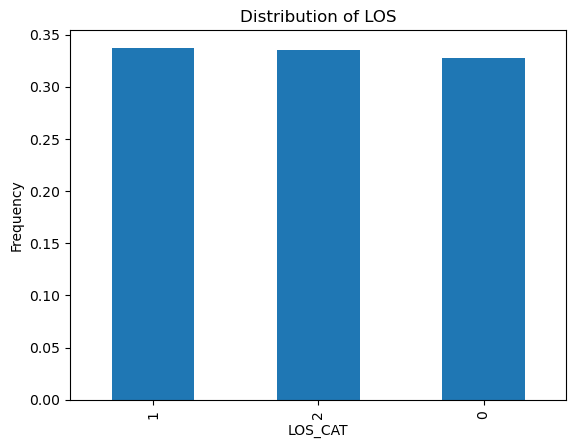

In [77]:
# check the data distribution of LOS
mimic_df["LOS_CAT"].value_counts(normalize=True).plot.bar()
plt.ylabel("Frequency")
plt.title(f"Distribution of LOS")

# Training

In [78]:
# split df into X and Y
Y = mimic_df["LOS_CAT"]
X = mimic_df.drop(["LOS", "LOS_CAT", "outtime", "intime"], axis=1)

In [79]:
X.shape

(479973, 9)

In [80]:
Y.shape

(479973,)

In [81]:
Y

0         1
1         1
2         1
3         1
4         1
         ..
479968    1
479969    1
479970    1
479971    2
479972    2
Name: LOS_CAT, Length: 479973, dtype: category
Categories (3, int64): [0 < 1 < 2]

In [82]:
# split into trainval and tes
X_trainval, X_test, Y_trainval, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=69)

In [83]:
# split train into train-val
X_train, X_val, Y_train, Y_val = train_test_split(X_trainval, Y_trainval, test_size=0.1, shuffle=True, random_state=21)

In [85]:
# scaler = StandardScaler()

In [86]:
scaler = MinMaxScaler()

In [87]:
#Documentation says its good to scale both X and Y especially for NNs
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Y_train_scaled = scaler.fit_transform(Y_train.values.reshape(-1,1))
# Y_val_scaled = scaler.fit_transform(Y_val.values.reshape(-1,1))
# Y_test_scaled = scaler.transform(Y_test.values.reshape(-1,1))

In [88]:
X_train_scaled.shape

(345580, 9)

In [89]:
X_val_scaled.shape

(38398, 9)

In [90]:
X_test_scaled.shape

(95995, 9)

In [91]:
Y_test.shape

(95995,)

In [93]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)
print(f"Using {device} device")

Using cpu device


In [165]:
batch_size = 64

# Convert train data to PyTorch tensors
X_train_tensor = torch.tensor(np.array(X_train_scaled), dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(np.array(Y_train), dtype=torch.long).to(device)

# Convert val data to PyTorch tensors
X_val_tensor = torch.tensor(np.array(X_val_scaled), dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(np.array(Y_val), dtype=torch.long).to(device)

# Convert test data to PyTorch tensors
X_test_tensor = torch.tensor(np.array(X_test_scaled), dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(np.array(Y_test), dtype=torch.long).to(device)

# Create a DataLoader for the training data
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Create a DataLoader for the validate data
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Create a DataLoader for the test data
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [95]:
train_loader.dataset

In [96]:
y_test_tensor

tensor([1, 2, 1,  ..., 2, 1, 2])

In [166]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size=50, output_size=3):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 20)
        self.fc3 = nn.Linear(20, output_size)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(50)
        self.batchnorm2 = nn.BatchNorm1d(20)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)

        x = self.fc2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc3(x)
        
        return x
        

In [167]:
model = NeuralNetwork(X_train_scaled.shape[1]).to(device)
model

NeuralNetwork(
  (fc1): Linear(in_features=9, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=3, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [172]:
crossentropy_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [169]:
def train(data, model, loss_fn, optimizer):
    size = len(data.dataset)
    model.train()
    total_loss, correct = 0, 0
    for batch, (X, y) in enumerate(data):
        X, y = X.to(device), y.to(device)
        
        optimizer.zero_grad()
        # compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
        # Bachpropagation
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
       
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"Train loss: {loss:>7f} [{current:>5d}/{size:>5d}]")
    return (total_loss / len(data)), (correct/ size)

In [170]:

def test(data, model, loss_fn):
    size = len(data.dataset)
    num_batches = len(data)
   
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():      
        for X, y in data:
            X, y = X.to(device), y.to(device)
            pred = model(X)
        
            test_loss += loss_fn(pred, y).item()
            
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error:\n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
   
    return test_loss, correct

In [ ]:
epochs = 100
total_train_loss = []
total_val_loss = []
total_train_acc = []
total_val_acc = []
for t in range(epochs):
    print(f"Epoch {t+1}\n -------------------")
    train_loss, train_acc = train(train_loader, model, crossentropy_loss, optimizer)
    total_train_loss.append(train_loss)
    total_train_acc.append(train_acc)
    val_loss, val_acc = test(val_loader, model, crossentropy_loss) 
    total_val_loss.append(val_loss)
    total_val_acc.append(val_acc)
print("Done!")

Epoch 1
 -------------------
Train loss: 1.052632 [    0/345580]
Train loss: 1.092445 [ 3200/345580]
Train loss: 1.030116 [ 6400/345580]
Train loss: 1.063921 [ 9600/345580]
Train loss: 1.020415 [12800/345580]
Train loss: 1.064226 [16000/345580]
Train loss: 1.107343 [19200/345580]
Train loss: 1.069378 [22400/345580]
Train loss: 1.056816 [25600/345580]
Train loss: 0.994606 [28800/345580]
Train loss: 1.005725 [32000/345580]
Train loss: 1.000736 [35200/345580]
Train loss: 1.017317 [38400/345580]
Train loss: 1.021270 [41600/345580]
Train loss: 1.101602 [44800/345580]
Train loss: 0.962362 [48000/345580]
Train loss: 1.038360 [51200/345580]
Train loss: 1.088483 [54400/345580]
Train loss: 1.019860 [57600/345580]
Train loss: 1.041482 [60800/345580]
Train loss: 1.022970 [64000/345580]
Train loss: 0.995930 [67200/345580]
Train loss: 1.033462 [70400/345580]
Train loss: 1.053937 [73600/345580]
Train loss: 1.104217 [76800/345580]
Train loss: 1.116058 [80000/345580]
Train loss: 1.016832 [83200/345580]

In [104]:
torch.save(model.state_dict(), "mimic.pth")

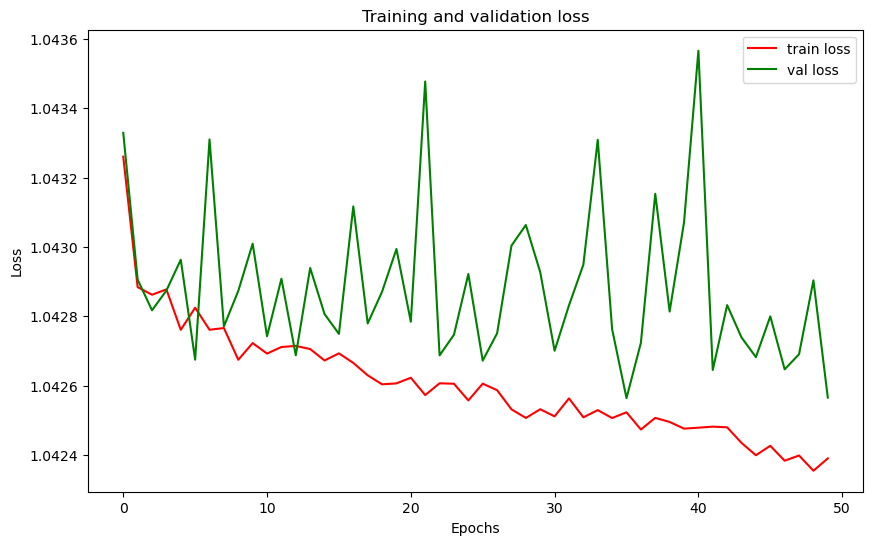

In [139]:
plt.figure(figsize=(10, 6))
plt.plot(total_train_loss, 'r', label='train loss')  # Plotting
plt.plot(total_val_loss, 'g', label='val loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

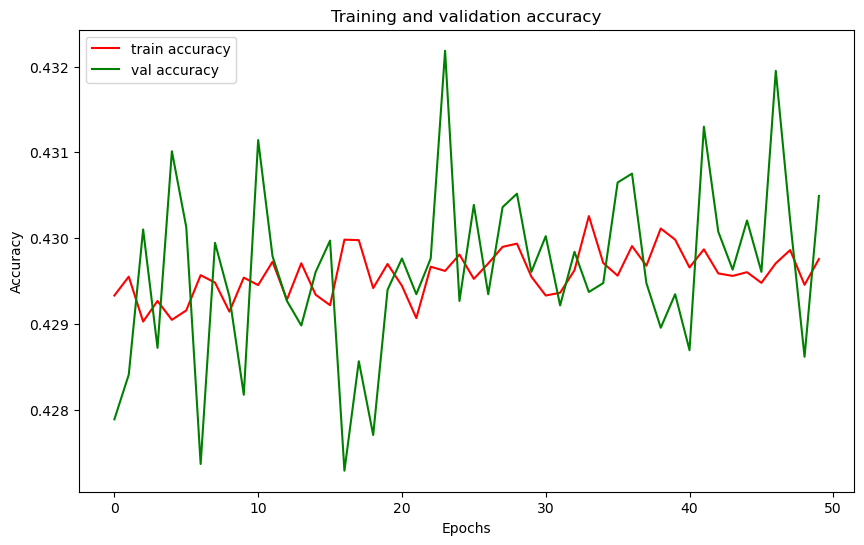

In [140]:
plt.figure(figsize=(10, 6))
plt.plot(total_train_acc, 'r', label='train accuracy')  # Plotting
plt.plot(total_val_acc, 'g', label='val accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [141]:
y_pred_list = []
total, correct = 0, 0
with torch.no_grad():
    model.eval()
    for data,labels in test_loader:
        data, labels = data.to(device), labels.to(device)
        y_test_pred = model(data)
        _, predicted = torch.max(y_test_pred.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_pred_list.extend(predicted.cpu().numpy())
accuracy = 100 * correct / total

In [110]:
accuracy

43.22620969842179

In [ ]:
len(test_loader.dataset)

In [121]:
len(y_pred_list)

95995

<Axes: >

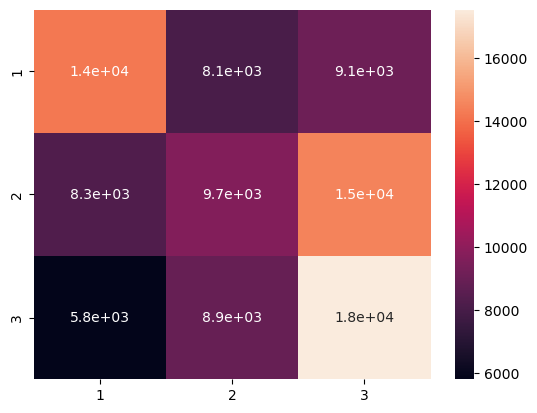

In [142]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(Y_test, y_pred_list)).rename(columns=idx2class, index=idx2class)

sns.heatmap(confusion_matrix_df, annot=True)

In [143]:
print(classification_report(Y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.50      0.45      0.48     31353
           1       0.36      0.30      0.33     32435
           2       0.43      0.54      0.48     32207

    accuracy                           0.43     95995
   macro avg       0.43      0.43      0.43     95995
weighted avg       0.43      0.43      0.43     95995



In [144]:
#save model
torch.save(model.state_dict(), "mimic.pth")
print("Saved PyTorch Mimic Model ")

Saved PyTorch Mimic Model 
